# Retrieval-Augmented Generation (RAG) with LangChain

RAG enhances LLMs by first **retrieving** relevant document chunks from a vector store, then **augmenting** the model’s context with those chunks before **generating** an answer.  
1. **Load & split** your documents (e.g. text, PDFs, web pages).  
2. **Embed** chunks into vectors and index in a DB (Chroma).  
3. **Retrieve** top-K relevant chunks for each query.  
4. **Generate** answers by feeding the retrieved context into an LLM chain (Gemini).
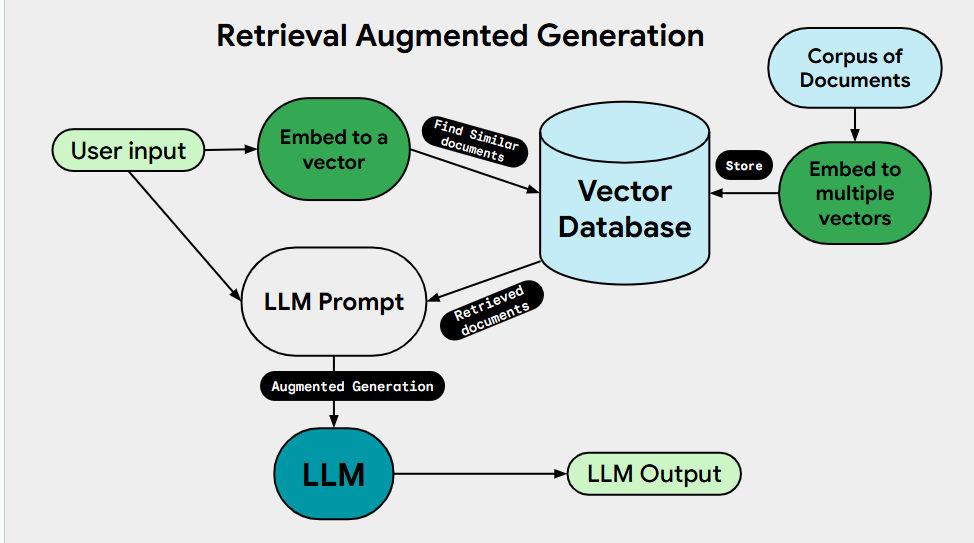  

# **First: Installing Packages and obtaining API Keys**:
Configure necessary packages and get youe API keys setup. remember to ask for **help** if you need anything! don't be shy!

### 🔑 Obtaining API Keys for Gemini & LangChain
**API keys** authenticate your requests, ensuring only you can access the service.  
They help track usage, enforce quotas or billing limits, and let you use cloud-hosted AI models without installing them locally.  
They protect the API from unauthorized or malicious use.  


**1. Get your free Gemini API key from Google AI Studio**  
1. Go to [Google AI Studio](https://ai.google.dev/aistudio) and sign in with your Google account.  
2. Navigate to **“API Keys”** in the left sidebar.  
3. Click **“Create Key”**, give it a name (e.g. `GeminiKey`), and copy the generated key.  
4. Store it in a secure place (e.g. Colab secret or environment variable).

**2. Get your LangChain (Langsmith) API key**  
1. Visit [Langsmith](https://www.langchain.com/langsmith) and log in or sign up.  
2. Open **“Account”** (top-right) → **“API Keys”**.  
3. Click **“New Key”**, name it (e.g. `LangChainKey`), and copy the value.  
4. Save it securely alongside your Gemini key.
**After you got the API keys Add them as a Secret in google colab:**

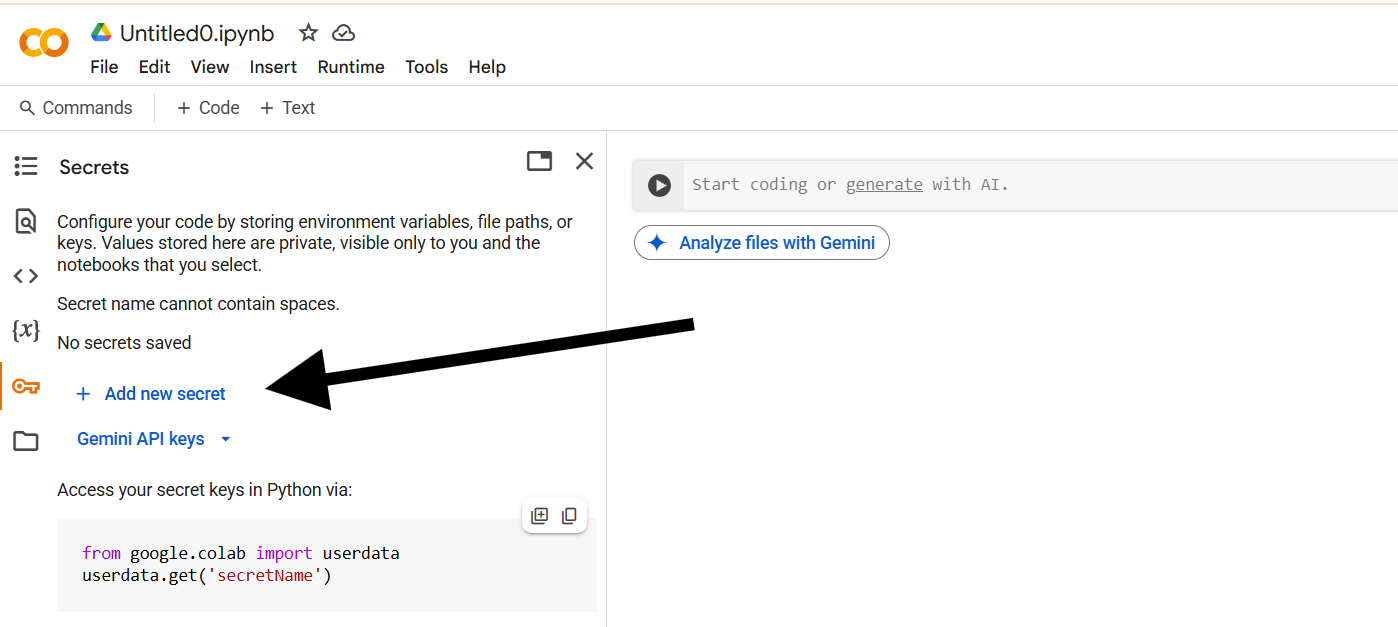

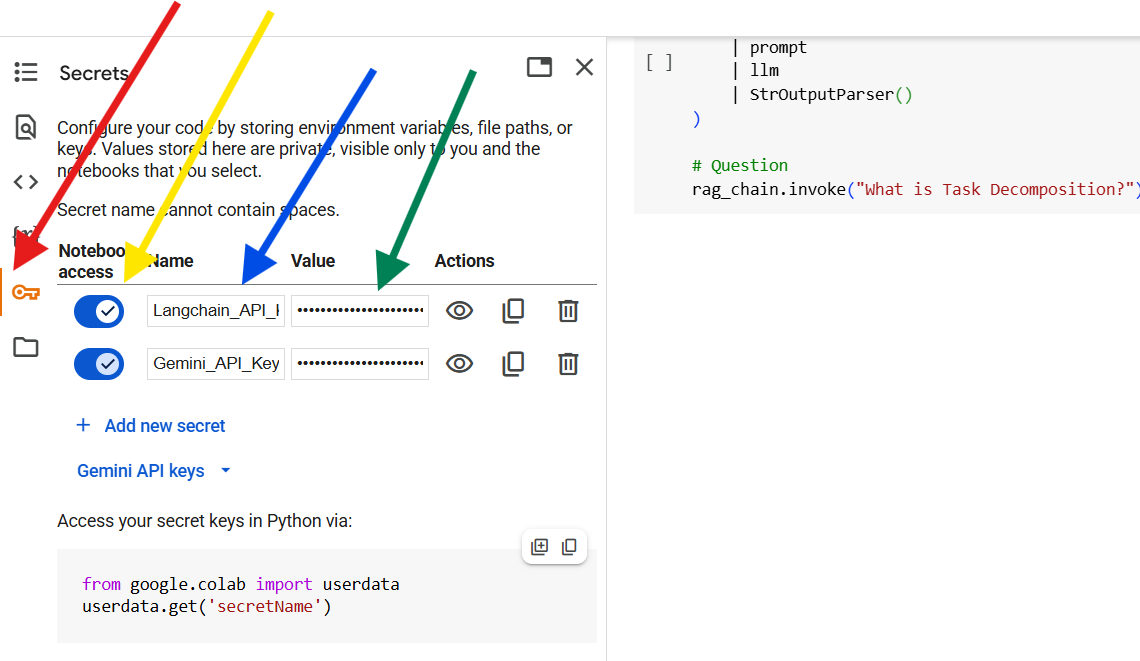

**Langchain API Setup**

In [ ]:
import os
from google.colab import userdata
key=userdata.get('Langchain_API_Key')

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = key

**Google Gemini API setup**

In [ ]:
from google.colab import userdata
key=userdata.get('Gemini_API_Key')
os.environ["GOOGLE_API_KEY"] = key

### Installing Packages
**Imports Explained (short & sweet)**

- `bs4` – BeautifulSoup: parse & clean HTML.  
- `hub` – LangChain Hub: load pre-built chains & components.  
- `RecursiveCharacterTextSplitter` – split long text into overlapping chunks.  
- `WebBaseLoader` – fetch URL content as plain text.  
- `Chroma` – vector DB: store & query embeddings.  
- `StrOutputParser` – ensure LLM output is a simple string.  
- `RunnablePassthrough` – no-op step to fit pipeline interfaces.  
- `ChatGoogleGenerativeAI` – Gemini chat model wrapper.  
- `GoogleGenerativeAIEmbeddings` – create text embeddings via Google API.  

**Run the code cell bellow to install all Packages. It might take some time, be patient !**


In [ ]:
! pip install pypdf langchain_community tiktoken langchain-google-genai langchainhub chromadb langchain

**Run the code cell bellow to import packages.**

In [ ]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

# **Second: Build A RAG Model**
Follow steps to Buiding a RAG Application and solve small tasks along the way!

## 1️⃣ **Load & Embed Documents**

1. **Fetch & Parse**  
   Use `WebBaseLoader` (with BeautifulSoup) to load the target webpage into a LangChain `Document`.  

2. **Split to Chunk**  
   Apply `RecursiveCharacterTextSplitter` to split the document into smaller, overlapping text chunks.  

3. **Embed**  
   Generate a vector for each chunk using your embedding model (`GoogleGenerativeAIEmbeddings`).  

4. **Store**  
   Store all chunk vectors in your chosen vector database (Chroma) for efficient retrieval.  


### **Fetch and Parse**

For this use case, I picked a web page about LLM powered AI Agents to help explain and simplify the process. (Optional) You can load a document from your computer if you prefer!!

In [ ]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

(Optional) load a PDF document from your computer

In [ ]:
from google.colab import files
from langchain.document_loaders import PyPDFLoader

uploaded = files.upload()                 # pops up file-picker button, click it to upload your file
file_path = next(iter(uploaded.keys()))   # get the first filename

loader = PyPDFLoader(file_path)
docs = loader.load()


KeyboardInterrupt: 

### **Split document into chunks**

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) #1000 char per chunk, allowed overlap between chunks is 200
splits = text_splitter.split_documents(docs)

 📋 **Task 1**

<mark>**🔹Write a code in the cell bellow to print out the splitted Chunks of the document**</mark>  

In [ ]:
for x in splits:
  print(x)
  # Your Code goes Here

page_content='LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory' metadata={'sour

### **Embed and store**

In [ ]:
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model)

 📋 **Task 2**

<mark>**🔹Write a code in the cell bellow to take a sneak peak at the content of the Vector Store, make the code print the embeddings of the first chunk in the vector store**</mark>  

In [ ]:
# hint: Vectore Stores store three things for each chunk(embeddings,documents,metadatas)'
vectorstore.get(include=['embeddings','documents','metadatas'])

NameError: name 'vectorstore' is not defined

## 2️⃣ **Retrieve & Generate Answers**

1. **Retrieve**  
   Use your vector store to find the top-K document chunks most relevant to the user’s question.

2. **Format Context**  
   Combine those chunks into a single text block so the model sees all the necessary background.

3. **Build Prompt**  
   Specify the LLM you intend to use and srtup desired tempreture.

4. **LLM Setup**  
   Pass the completed prompt to your LLM (e.g. Gemini) to produce a grounded answer.

5. **Chain and Output Generation**  
   Setup a Chain for the RAG application then generate output.  


### **Retrieve**

In [ ]:
retriever = vectorstore.as_retriever()

Run the Following code to inspect the retrieved documents from the Vector Store, relevant documents to any question are calculated with **Cosine Similarity**.

In [ ]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

<ipython-input-13-199d1ce08656>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("What is Task Decomposition?")


 📋 **Task 3**

<mark>**🔹Write a code in the cell below that prints each retrieved document and then displays the number of retrieved documents.**</mark>  

In [ ]:
# your code goes here
print('Retreived docs:')
for doc in docs:
  print(doc)

print()
print('Number of retreived docs: ', len(docs))

Retreived docs:
page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.' metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (bread

 📋 **Task 4**

<mark>**🔹The number of retrieved documents is currently fixed by default. Update the code in one of the previous cells so that it returns the top seven documents most relevant to the question. Recheck if the top-k retrieved documents has changed**</mark>  

In [ ]:
# your code goes here


NameError: name 'vectorstore' is not defined

### **Format Context**

Define a function that will be used later to combine all retrieved chunks from the vector DB into a one context.

In [ ]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### **Build a Prompt**

In [ ]:
prompt = hub.pull("rlm/rag-prompt")

NameError: name 'hub' is not defined

### **Define a link to a LLM**

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

 📋 **Task 5**

<mark>**🔹What does the parameter "tempreture" do? write a short answer in the text cell bellow**</mark>  

Tempreture is....(YOUR_ANSWER)

### **Chain and Output Generation**

Setup a chain that will link the user question and all retrieved documents to the large language model.

In [ ]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")